# Feature matrices optimization

In [1]:
import numpy as np
from pyHSICLasso.hsic_lasso import compute_kernel
from pyHSICLasso.kernel_tools import kernel_gaussian
from numba import njit, prange
import matplotlib.pyplot as plt

from hsic_optimization.benchmark import generate_data

In [2]:
%load_ext line_profiler

In [3]:
X = generate_data(10000, 1, 1, seed=12345)[0].T

In [4]:
%%timeit
compute_kernel(X, "Gaussian", B=20, M=3)

144 ms ± 2.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [5]:
%lprun -f compute_kernel compute_kernel(X, "Gaussian", B=20, M=3)

Timer unit: 1e-06 s

Total time: 0.259664 s
File: /home/riom/project/hsic_optimization/venv/lib/python3.8/site-packages/pyHSICLasso/hsic_lasso.py
Function: compute_kernel at line 53

Line #      Hits         Time  Per Hit   % Time  Line Contents
    53                                           def compute_kernel(x, kernel, B = 0, M = 1, discarded = 0):
    54                                           
    55         1         14.0     14.0      0.0      d,n = x.shape
    56                                           
    57         1         90.0     90.0      0.0      H = np.eye(B, dtype=np.float32) - 1 / B * np.ones(B, dtype=np.float32)
    58         1        357.0    357.0      0.1      K = np.zeros(n * B * M, dtype=np.float32)
    59                                           
    60                                               # Normalize data
    61         1          2.0      2.0      0.0      if kernel == "Gaussian":
    62         1        343.0    343.0      0.1          x = 

In [6]:
X_k = X[:, :20]

In [7]:
%%timeit
kernel_gaussian(X_k, X_k, 1.0)

55.6 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [8]:
def kernel_gaussian_1(x):
    return np.exp(-((x - x.T) ** 2) * 0.5)


np.allclose(kernel_gaussian(X_k, X_k, 1.0), kernel_gaussian_1(X_k))

True

In [9]:
%%timeit
kernel_gaussian_1(X_k)

11.5 µs ± 80.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
@njit
def kernel_gaussian_2(x):
    return np.exp(-((x - x.T) ** 2) * 0.5)


np.allclose(kernel_gaussian(X_k, X_k, 1.0), kernel_gaussian_2(X_k))

True

In [11]:
%%timeit
kernel_gaussian_2(X_k)

5.88 µs ± 70 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [12]:
@njit
def kernel_gaussian_3(x):
    _, n = x.shape
    out = np.empty((n, n), dtype=np.float64)
    for i in range(n):
        for j in range(i, n):
            res = np.exp(-((x[0, i] - x[0, j]) ** 2) * 0.5)
            out[i, j] = res
            out[j, i] = res
    return out


np.allclose(kernel_gaussian(X_k, X_k, 1.0), kernel_gaussian_3(X_k))

True

In [13]:
%%timeit
kernel_gaussian_3(X_k)

3.59 µs ± 10.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [14]:
@njit
def kernel_gaussian_4(x):
    _, n = x.shape
    out = np.ones((n, n), dtype=np.float64)
    _, indices = np.nonzero(X_k)
    for i in indices:
        for j in range(n):
            res = np.exp(-((x[0, i] - x[0, j]) ** 2) * 0.5)
            out[i, j] = res
            out[j, i] = res
    return out


np.allclose(kernel_gaussian(X_k, X_k, 1.0), kernel_gaussian_4(X_k))

True

In [15]:
%%timeit
kernel_gaussian_4(X_k)

3.06 µs ± 151 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [16]:
lookup = kernel_gaussian_1(np.array([[0, 1, 2]]))
np.allclose(kernel_gaussian(X_k, X_k, 1.0), lookup[X_k, X_k.T])

True

In [17]:
%%timeit
lookup[X_k, X_k.T]

3.5 µs ± 276 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [18]:
@njit
def kernel_gaussian_5(x, lookup):
    _, n = x.shape
    out = np.empty((n, n), dtype=lookup.dtype)
    for i in range(n):
        for j in range(i, n):
            res = lookup[x[0, i], x[0, j]]
            out[i, j] = res
            out[j, i] = res
    return out


np.allclose(kernel_gaussian(X_k, X_k, 1.0), kernel_gaussian_5(X_k, lookup))

True

In [19]:
%%timeit
kernel_gaussian_5(X_k, lookup)

1.49 µs ± 20.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


## Accelerate `compute_kernel`

In [20]:
%%timeit
compute_kernel(X, "Gaussian", B=20, M=3)

144 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
def compute_kernel_1(x, B=0, M=1, discarded=0):
    d, n = x.shape

    H = np.eye(B, dtype=np.float32) - 1 / B * np.ones(B, dtype=np.float32)
    K = np.zeros(n * B * M, dtype=np.float32)

    arr = np.array([[0, 1, 2]])
    x_std = x.std() + 1e-19
    lookup = kernel_gaussian(arr / x_std, arr / x_std, 1.0).astype(np.float32)

    st = 0
    ed = B**2
    index = np.arange(n)
    for m in range(M):
        np.random.seed(m)
        index = np.random.permutation(index)
        X_k = x[:, index]

        for i in range(0, n - discarded, B):
            j = min(n, i + B)

            k = lookup[X_k[:, i:j], X_k[:, i:j].T]
            k = np.dot(np.dot(H, k), H)
            k = k / (np.linalg.norm(k, "fro") + 10e-10)

            K[st:ed] = k.flatten()
            st += B**2
            ed += B**2

    return K


np.allclose(compute_kernel(X, "Gaussian", B=20, M=3), compute_kernel_1(X, B=20, M=3))

True

In [22]:
%%timeit
compute_kernel_1(X, B=20, M=3)

44.7 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
arr = np.array([[0, 1, 2]])
x_std = X.std() + 1e-19
lookup = kernel_gaussian(arr / x_std, arr / x_std, 1.0).astype(np.float32)


def compute_kernel_2a(x, lookup, B=0, M=1, discarded=0):
    _, n = x.shape
    H = np.eye(B, dtype=np.float32) - np.full((B, B), 1 / B, dtype=np.float32)
    K = np.zeros(n * B * M, dtype=np.float32)

    st = 0
    ed = B**2
    index = np.arange(n)
    for m in range(M):
        np.random.seed(m)
        index = np.random.permutation(index)
        X_k = x[:, index]

        for i in range(0, n - discarded, B):
            j = min(n, i + B)

            k = kernel_gaussian_5(X_k[:, i:j], lookup)
            k = (H @ k) @ H
            k = k / (np.sqrt(np.sum(k**2)) + 1e-9)

            K[st:ed] = k.ravel()
            st += B**2
            ed += B**2

    return K


np.allclose(
    compute_kernel(X, "Gaussian", B=20, M=3), compute_kernel_2a(X, lookup, B=20, M=3)
)

True

In [24]:
compute_kernel_2b = njit(compute_kernel_2a)

np.allclose(
    compute_kernel(X, "Gaussian", B=20, M=3), compute_kernel_2b(X, lookup, B=20, M=3)
)

False

Unfortunately the acceletated version (using numba) of `compute_kernel_2a` doesn't
return exactly the same results as the non-accelerated version. This is happening
when the matrix $k$ is full of ones, such that $H . k . H$ should be only zeros.
Due to differences in precision between the accelerated and non-accelerated versions,
the normalized results are different (the matrix norm being very close to zeros).

The following code explore in more details this corner case.

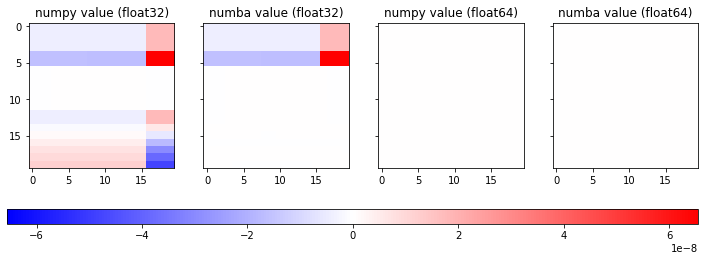

In [25]:
B = 20
H = np.eye(B, dtype=np.float32) - np.full((B, B), 1 / B, dtype=np.float32)
k = np.ones((B, B), dtype=np.float32)


@njit
def matmul(H, k):
    return (H @ k) @ H


numpy32_value = (H @ k) @ H
numba32_value = matmul(H, k)

H = H.astype(np.float64)
k = k.astype(np.float64)

numpy64_value = (H @ k) @ H
numba64_value = matmul(H, k)

fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)

vmax = np.max(np.abs([numpy32_value, numba32_value, numpy64_value, numba64_value]))
vmin = -vmax

im = axes[0].imshow(numpy32_value, vmin=vmin, vmax=vmax, cmap="bwr")
axes[0].set_title("numpy value (float32)")

axes[1].imshow(numba32_value, vmin=vmin, vmax=vmax, cmap="bwr")
axes[1].set_title("numba value (float32)")

axes[2].imshow(numpy64_value, vmin=vmin, vmax=vmax, cmap="bwr")
axes[2].set_title("numpy value (float64)")

axes[3].imshow(numba64_value, vmin=vmin, vmax=vmax, cmap="bwr")
axes[3].set_title("numba value (float64)")

fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.1, 0, 0.8, 0.05])
_ = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")

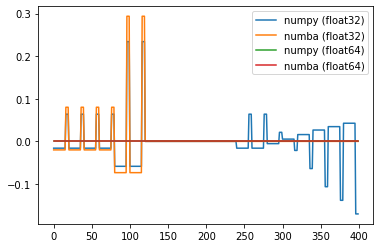

In [26]:
def normed_values(x):
    return x.ravel() / (np.sqrt(np.sum(x**2)) + 1e-9)


plt.plot(normed_values(numpy32_value), label="numpy (float32)")
plt.plot(normed_values(numba32_value), label="numba (float32)")
plt.plot(normed_values(numpy64_value), label="numpy (float64)")
plt.plot(normed_values(numba64_value), label="numba (float64)")
_ = plt.legend()

In [27]:
%%timeit
compute_kernel_2b(X, lookup, B=20, M=3)

7.77 ms ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
@njit(nogil=True)
def kernel_gaussian_6(x, lookup):
    n = len(x)
    out = np.empty((n, n), dtype=lookup.dtype)
    for i in range(n):
        for j in range(i, n):
            res = lookup[x[i], x[j]]
            out[i, j] = res
            out[j, i] = res
    return out


@njit(parallel=True)
def compute_kernel_3(x, lookup, B=0, M=1, discarded=0):
    _, n = x.shape
    K = np.zeros(n * B * M, dtype=np.float32)
    H = np.eye(B, dtype=np.float32) - np.full((B, B), 1 / B, dtype=np.float32)

    index = np.arange(n)
    for m in range(M):
        np.random.seed(m)
        index = np.random.permutation(index)
        X_k = x[0][index]

        for i in prange(n // B):
            ik = i * B
            jk = min(n, ik + B)

            k = kernel_gaussian_6(X_k[ik:jk], lookup)
            k = (H @ k) @ H
            k = k / (np.sqrt(np.sum(k**2)) + 1e-9)

            st = m * n * B + i * B**2
            ed = st + B**2
            K[st:ed] = k.ravel()

    return K


np.allclose(
    compute_kernel(X, "Gaussian", B=20, M=3), compute_kernel_3(X, lookup, B=20, M=3)
)

/home/riom/project/hsic_optimization/venv/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


False

In [29]:
%%timeit
compute_kernel_3(X, lookup, B=20, M=3)

6.87 ms ± 98.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
X2 = generate_data(100000, 1, 1, seed=12345)[0].T

In [31]:
%%timeit
compute_kernel_2b(X2, lookup, B=20, M=3)

83.5 ms ± 2.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [32]:
%%timeit
compute_kernel_3(X2, lookup, B=20, M=3)

49.2 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
X3 = generate_data(1000000, 1, 1, seed=12345)[0].T

In [34]:
%%timeit
compute_kernel_2b(X3, lookup, B=20, M=3)

899 ms ± 14.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%%timeit
compute_kernel_3(X3, lookup, B=20, M=3)

484 ms ± 8.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Accelerate multiple features retrieval

The scenario we want to accelerate here is when multiple features need to be
computed.

In [36]:
B = 20
M = 3

In [37]:
X, _ = generate_data(10000, 100, 20, seed=12345)
X.shape

(10000, 100)

In [38]:
np.random.seed(42)
indices = np.random.choice(X.shape[1], 20, replace=False)

We transpose the input $X$ just to make sure that we fetch columns as fast as
possible.

In [39]:
X = X.T.copy()
X.shape

(100, 10000)

The first version use an helper function to extract each column of the HSIC
feature matrix and combine them using a simple list comprehension.

In [40]:
def feature(X, B, M):
    X = X.reshape(1, -1)

    arr = np.array([[0, 1, 2]])
    X_std = X.std() + 1e-19
    lookup = kernel_gaussian(arr / X_std, arr / X_std, 1).astype(np.float32)

    scale = np.sqrt(B / (X.size * M))
    return compute_kernel_2b(X, lookup, B=B, M=M) * scale


def features(seq, X, B, M):
    return np.array([feature(X[i], B, M) for i in seq])

In [41]:
%timeit features(indices, X, B, M)

194 ms ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A second version constists in preallocating the result array, to save a copy and
some memory.

In [42]:
def features_2(seq, X, B, M):
    cols = np.empty((len(seq), X.shape[1] * M * B), dtype=np.float32)
    for i, idx in enumerate(seq):
        cols[i] = feature(X[idx], B, M)
    return cols


np.allclose(features(indices, X, B, M), features_2(indices, X, B, M))

True

In [43]:
%timeit features_2(indices, X, B, M)

185 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Another thing we can try is to use `numba` to accelerate the loop over features.
We need to change the `feature` function to be jit-able too.

In [44]:
kernel_gaussian_1b = njit(kernel_gaussian_1)


@njit
def feature_3(X, B, M):
    X = X.reshape(1, -1)

    arr = np.array([[0, 1, 2]])
    X_std = X.std() + 1e-19
    lookup = kernel_gaussian_1b(arr / X_std).astype(np.float32)

    scale = np.sqrt(B / (X.size * M))
    return compute_kernel_2b(X, lookup, B=B, M=M) * scale


@njit
def features_3(seq, X, B, M):
    cols = np.empty((len(seq), X.shape[1] * M * B), dtype=np.float32)
    for i, idx in enumerate(seq):
        cols[i] = feature_3(X[idx], B, M)
    return cols


np.allclose(features(indices, X, B, M), features_3(indices, X, B, M))

True

In [45]:
%timeit features_3(indices, X, B, M)

199 ms ± 7.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The loop of features could be run in parallel using multiple threads, that's
what we will try next.

In [46]:
@njit(parallel=True)
def features_4(seq, X, B, M):
    cols = np.empty((len(seq), X.shape[1] * M * B), dtype=np.float32)
    for i in prange(len(seq)):
        idx = seq[i]
        cols[i] = feature_3(X[idx], B, M)
    return cols


np.allclose(features(indices, X, B, M), features_4(indices, X, B, M))

True

In [47]:
%timeit features_4(indices, X, B, M)

97.4 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


This last version seems to be able to provide a good speed-up (almost 2X here).